In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import seaborn as sns

## Load in the prediction data

In [2]:
predictions = []

for week_eval in [9]:

  preds_week = pd.read_csv(f"/home/sam/repos/hobby-repos/nfl/data/processed/tracking_week_{week_eval}_preds.csv")
  print(preds_week.head())
  predictions.append(preds_week)
  print(f"Finished processing week {week_eval}...")

predictions_df = pd.concat(predictions, ignore_index=True)
predictions_df['base_correct'] = predictions_df['pred'] == predictions_df['actual']
print(predictions_df.head())

       gameId  playId    nflId      displayName  frameId    frameType  \
0  2022110700      56  33131.0  Calais Campbell        1  BEFORE_SNAP   
1  2022110700      56  33131.0  Calais Campbell        2  BEFORE_SNAP   
2  2022110700      56  33131.0  Calais Campbell        3  BEFORE_SNAP   
3  2022110700      56  33131.0  Calais Campbell        4  BEFORE_SNAP   
4  2022110700      56  33131.0  Calais Campbell        5  BEFORE_SNAP   

                    time  jerseyNumber club playDirection  ...  defense  week  \
0  2022-11-08 01:16:09.2          93.0  BAL          left  ...        1     9   
1  2022-11-08 01:16:09.3          93.0  BAL          left  ...        1     9   
2  2022-11-08 01:16:09.4          93.0  BAL          left  ...        1     9   
3  2022-11-08 01:16:09.5          93.0  BAL          left  ...        1     9   
4  2022-11-08 01:16:09.6          93.0  BAL          left  ...        1     9   

        uniqueId    frameUniqueId  snap_frame  frames_from_snap  zone_prob

In [3]:
predictions_df.columns

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a',
       'dis', 'o', 'dir', 'event', 'o_clean', 'dir_clean', 'x_clean',
       'y_clean', 's_clean', 'a_clean', 'dis_clean', 'dir_radians', 'v_x',
       'v_y', 'passAttempt', 'possessionTeam', 'defensiveTeam', 'pff_manZone',
       'defense', 'week', 'uniqueId', 'frameUniqueId', 'snap_frame',
       'frames_from_snap', 'zone_prob', 'man_prob', 'pred', 'actual',
       'base_correct'],
      dtype='object')

## Plot accuracy vs frames pre snap across Week 9

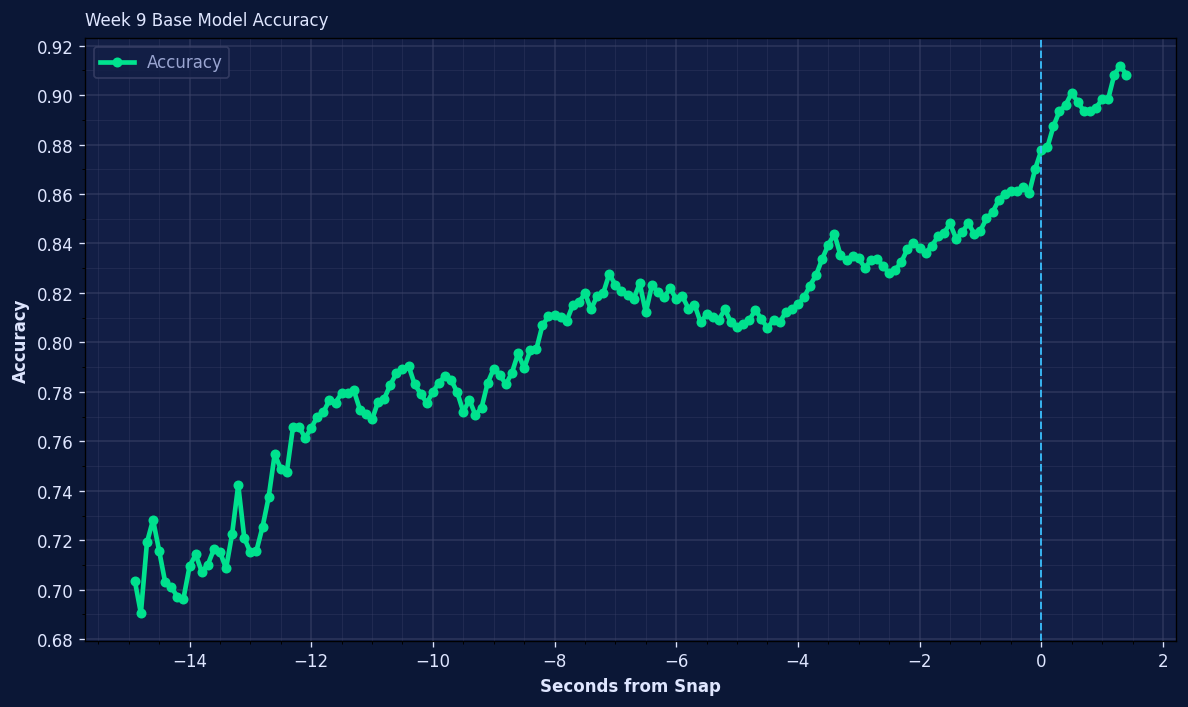

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Take 15s before snap and 1.5s post snap then create a new human readable column
week_9_df = predictions_df[
    (predictions_df['week'] == 9)
    & (predictions_df['frames_from_snap'] < 15)
    & (predictions_df['frames_from_snap'] > -150)
].copy()
week_9_df['seconds_from_snap'] = week_9_df['frames_from_snap'] / 10

# Group all the rows of the same time step together then take the mean of those rows (1 or 0) to yield accuracy
accuracy_by_frame = week_9_df.groupby('seconds_from_snap')['base_correct'].mean()

# Colors (NGS-ish palette)
BG      = "#0b1736"   # dark navy
AX_BG   = "#121e45"   # panel navy
GRID    = "#3b4268"   # grid gray-blue
LINE    = "#00e28e"   # neon green
ACCENT  = "#39c0ff"   # cyan for highlights
TEXT    = "#dfe6ff"   # off-white text
SUBT    = "#9aa5d1"   # subdued text

fig, ax = plt.subplots(figsize=(10, 6), dpi=120, facecolor=BG)
ax.set_facecolor(AX_BG)

# Plot
ax.plot(
    accuracy_by_frame.index,
    accuracy_by_frame.values,
    marker='o',
    linestyle='-',
    linewidth=2.8,
    markersize=5,
    color=LINE,
    label='Accuracy'
)


# Grid + ticks (match animation)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

ax.grid(True, which="major", color=GRID, linewidth=1.0, alpha=0.6)
ax.grid(True, which="minor", color=GRID, linewidth=0.6, alpha=0.35)

# Vertical line at snap (t = 0)
ax.axvline(0.0, color=ACCENT, linestyle="--", linewidth=1.2, alpha=0.9)

# Labels & title (dark theme)
ax.set_xlabel("Seconds from Snap", color=TEXT, fontweight="bold")
ax.set_ylabel("Accuracy", color=TEXT, fontweight="bold")
ax.set_title("Week 9 Base Model Accuracy", loc="left", pad=8, color=TEXT, fontsize=10)

# Tick colors
ax.yaxis.set_major_locator(MultipleLocator(0.02))  # tick every 0.02
ax.tick_params(axis='x', colors=TEXT)
ax.tick_params(axis='y', colors=TEXT)

# Legend styling
legend = ax.legend(facecolor=AX_BG, edgecolor=GRID)
for text in legend.get_texts():
    text.set_color(SUBT)

fig.tight_layout()
plt.show()

## Grab plays that have the largest increase in man coverage proabability, end with over 80% man probability, and are passes

In [5]:
# Get a df that is only pre snap and pass attempts, also that is sorted by frames from snap
pre_snap_df = predictions_df[(predictions_df['frames_from_snap'] < 0) & (predictions_df['passAttempt'] == 1)].copy()
pre_snap_df = pre_snap_df.sort_values(['gameId', 'playId', 'frames_from_snap'])

# For each play, get the min (earliest frame) and max (latest pre-snap frame) man_prob
change_df = pre_snap_df.groupby(['gameId', 'playId']).agg(
    man_prob_start=('man_prob', 'first'),  # Assign first value of man probability to man_prob_start
    man_prob_end=('man_prob', 'last')      # Assign last value of man probability to man_prob end
).reset_index()

# Compute the largest change and create a view that is this sorted
change_df['man_prob_change'] = change_df['man_prob_end'] - change_df['man_prob_start']
largest_man_prob_increase = change_df.sort_values('man_prob_change', ascending=False)
largest_man_prob_increase = largest_man_prob_increase[largest_man_prob_increase['man_prob_end'] > 0.8]
top_50_plays = largest_man_prob_increase.head(50)
print(top_50_plays.head(50))

         gameId  playId  man_prob_start  man_prob_end  man_prob_change
462  2022110606    2868        0.088892      0.856261         0.767369
742  2022110610    3836        0.113602      0.872288         0.758687
119  2022110601     394        0.105599      0.841861         0.736262
766  2022110700     567        0.136234      0.871605         0.735371
224  2022110603     250        0.211062      0.944661         0.733599
607  2022110609     582        0.191812      0.923659         0.731848
598  2022110609     105        0.151426      0.882540         0.731114
701  2022110610    1617        0.117710      0.826161         0.708451
124  2022110601     802        0.135883      0.838525         0.702642
699  2022110610    1461        0.129331      0.821083         0.691753
539  2022110608     247        0.165391      0.856897         0.691506
702  2022110610    1740        0.136020      0.820747         0.684727
167  2022110602     124        0.234146      0.914454         0.680309
104  2

## Merge plays df and predictions df

Load in plays df

In [6]:
plays_df = pd.read_parquet('/home/sam/repos/hobby-repos/nfl/data/parquet/plays.parquet')
print(plays_df.columns)

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'defensiveTeam', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
       'playNullifiedByPenalty', 'absoluteYardlineNumber',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'offenseFormation', 'receiverAlignment',
       'playClockAtSnap', 'passResult', 'passLength', 'targetX', 'targetY',
       'playAction', 'dropbackType', 'dropbackDistance', 'passLocationType',
       'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
       'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
       'rushLocationType', 'penaltyYards', 'prePenaltyYardsGained',
       'yardsGained', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPointsAdded', 'isDropback',
       'pff_runConceptPrimary', 'pff_runConceptSecondary', 'pff_runPassOption',
       'pff_pass

Merge the plays_df and the predictions_df together

In [7]:
merged_df = predictions_df.merge(
    plays_df,
    on=['gameId', 'playId'],
    how='left'
)
print(merged_df.columns)

Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'frameType',
       'time', 'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a',
       'dis', 'o', 'dir', 'event', 'o_clean', 'dir_clean', 'x_clean',
       'y_clean', 's_clean', 'a_clean', 'dis_clean', 'dir_radians', 'v_x',
       'v_y', 'passAttempt', 'possessionTeam_x', 'defensiveTeam_x',
       'pff_manZone_x', 'defense', 'week', 'uniqueId', 'frameUniqueId',
       'snap_frame', 'frames_from_snap', 'zone_prob', 'man_prob', 'pred',
       'actual', 'base_correct', 'playDescription', 'quarter', 'down',
       'yardsToGo', 'possessionTeam_y', 'defensiveTeam_y', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'preSnapHomeScore',
       'preSnapVisitorScore', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'expectedPoints',
       'offenseFormation', 'receiverAlignment', 'playClockAtSnap',
       'passResult', 'passLength', '

## For the top man probability increase plays, plot the man probability across frames

In [8]:
def animate_play(game_id, play_id, quarter, play_description, actual_coverage, specific_coverage):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from matplotlib.ticker import MultipleLocator, AutoMinorLocator

    # Create the unique id for lookup in our df
    uuid = f"{game_id}_{play_id}"

    # Create the plot df
    plot_df = week_9_df[
        (week_9_df['uniqueId'] == uuid) &
        (week_9_df['frames_from_snap'] < 300) &
        (week_9_df['frames_from_snap'] > -200)
    ].copy()
    plot_df['seconds_from_snap'] = plot_df['frames_from_snap'] / 10     # Create human readable seconds (frames are at 10 Hz)
    plot_df = plot_df.sort_values('seconds_from_snap')                  # Sort for seconds from snap
    plot_df = plot_df.dropna(subset=['man_prob'])                       # Drop rows with missing y to avoid NaN issues
    plot_df = plot_df.iloc[::10, :].reset_index(drop=True)              # Downsample (since frame logging at 10 Hz, logging at 1 Hz)
    if plot_df.empty:
        print(f"[skip] No frames for {uuid}")
        return

    # Push to numpy
    x_all = plot_df['seconds_from_snap'].to_numpy()
    y_all = plot_df['man_prob'].to_numpy()

    # Colors (NGS-ish palette)
    BG      = "#0b1736"   # dark navy
    AX_BG   = "#121e45"   # panel navy
    GRID    = "#3b4268"   # grid gray-blue
    LINE    = "#00e28e"   # neon green
    ACCENT  = "#39c0ff"   # cyan for highlights
    TEXT    = "#dfe6ff"   # off-white text
    SUBT    = "#9aa5d1"   # subdued text

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=120, facecolor=BG)
    ax.set_facecolor(AX_BG)
    (line,) = ax.plot([], [], lw=2.8, color=LINE, label="Man Probability")
    dot = ax.plot([], [], marker="o", markersize=6, color=ACCENT, lw=0)[0]
    txt = ax.text(0.99, 0.98, "", transform=ax.transAxes, ha="right", va="top", color=SUBT, fontsize=10)
    ax.set_xlim(x_all.min(), x_all.max())
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.grid(True, which="major", color=GRID, linewidth=1.0, alpha=0.6)
    ax.grid(True, which="minor", color=GRID, linewidth=0.6, alpha=0.35)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    # Create title text
    coverage = "Man" if actual_coverage == 1 else "Zone"
    title_text = f"Q{quarter}: {play_description}\n Actual Coverage: {coverage} - {specific_coverage}\n"

    # Continued formatting
    ax.set_title(title_text, loc="left", pad=8, color=TEXT, fontsize=10)
    ax.set_xlabel("Seconds from Snap", color=TEXT, fontweight="bold")
    ax.set_ylabel("Man Probability", color=TEXT, fontweight="bold")
    ax.axvline(0.0, color=ACCENT, linestyle="--", linewidth=1.2, alpha=0.9)

    # Make tick labels match dark theme
    ax.tick_params(axis='x', colors=TEXT)
    ax.tick_params(axis='y', colors=TEXT)

    ##########################################################
    # Animation
    ##########################################################
    def init():
        line.set_data([], [])
        dot.set_data([], [])
        txt.set_text("")
        return (line, dot, txt)

    def update(i):
        # i goes from 0..len(x_all)-1
        x = x_all[:i+1]          # include current frame
        y = y_all[:i+1]
        line.set_data(x, y)
        # IMPORTANT: wrap scalars as sequences
        dot.set_data([x[-1]], [y[-1]])
        txt.set_text(f"t = {x[-1]:.2f}s   P(man) = {y[-1]:.2f}")
        return (line, dot, txt)

    ani = animation.FuncAnimation(
        fig, update, frames=len(x_all),
        init_func=init, blit=True, interval=1, repeat=False
    )

    fig.tight_layout()
    ani.save(
        f"play_{uuid}.gif",
        writer="pillow",
        fps=60
    )
    plt.close(fig)

In [9]:
for idx, row in top_50_plays.iterrows():
    play = merged_df[(merged_df['playId'] == row['playId']) & (merged_df['gameId'] == row['gameId'])]
    if play['passResult'].values[0] == 'C':
        print(f"gameId: {play['gameId'].iloc[0]}, playId: {play['playId'].iloc[0]}, Q: {play['quarter'].iloc[0]}, {play['playDescription'].iloc[0]}")
        animate_play(
            game_id=play['gameId'].iloc[0],
            play_id=play['playId'].iloc[0],
            quarter=play['quarter'].iloc[0],
            play_description=play['playDescription'].iloc[0],
            actual_coverage=play['actual'].iloc[0],
            specific_coverage=play['pff_passCoverage'].iloc[0],
            )

gameId: 2022110610, playId: 3836, Q: 4, (1:47) (Shotgun) P.Mahomes pass short left to J.McKinnon to KC 40 for 4 yards (A.Adams).
gameId: 2022110601, playId: 394, Q: 1, (8:28) (Shotgun) T.Tagovailoa pass deep middle to T.Sherfield to CHI 33 for 18 yards (E.Jackson).
gameId: 2022110609, playId: 582, Q: 1, (5:55) (Shotgun) M.Stafford pass short right to Al.Robinson to LA 36 for 4 yards (C.Davis).
gameId: 2022110601, playId: 802, Q: 1, (:18) (Shotgun) J.Fields pass short right to D.Mooney pushed ob at MIA 18 for 10 yards (K.Kohou).
gameId: 2022110610, playId: 1461, Q: 2, (6:51) (Shotgun) M.Willis pass deep left to A.Hooper to KC 2 for 18 yards (J.Thornhill).
gameId: 2022110602, playId: 124, Q: 1, (13:41) (Shotgun) J.Burrow pass short middle to H.Hurst to CIN 23 for 5 yards (M.Hartsfield).
gameId: 2022110607, playId: 2827, Q: 4, (14:20) T.Heinicke pass short right to D.Milne for 6 yards, TOUCHDOWN.
gameId: 2022110600, playId: 1233, Q: 2, (5:53) (Shotgun) J.Herbert pass short right to M.Band